## Import Packages and Load Data

In [1]:
# before running everything, create a new conda environment with python 3.10 installed 
# conda env create -n "myEnv" python=3.10
# conda activate myEnv 
# pip install torch torchvision matplotlib seaborn umap-learn umap-learn[plot] xgboost scikit-learn nltk
# conda install numpy pandas 

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import * 
import xgboost
import umap
import umap.plot
import warnings
warnings.filterwarnings('ignore')

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [35]:
train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))
train_data.dropna(inplace=True)
X, y = train_data.drop(["price"], axis=1), train_data["price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_test = test_data
X_train, X_val, X_test = preprocess(X_train), preprocess(X_val), preprocess(X_test)

### Boxplots of Postprocessed features

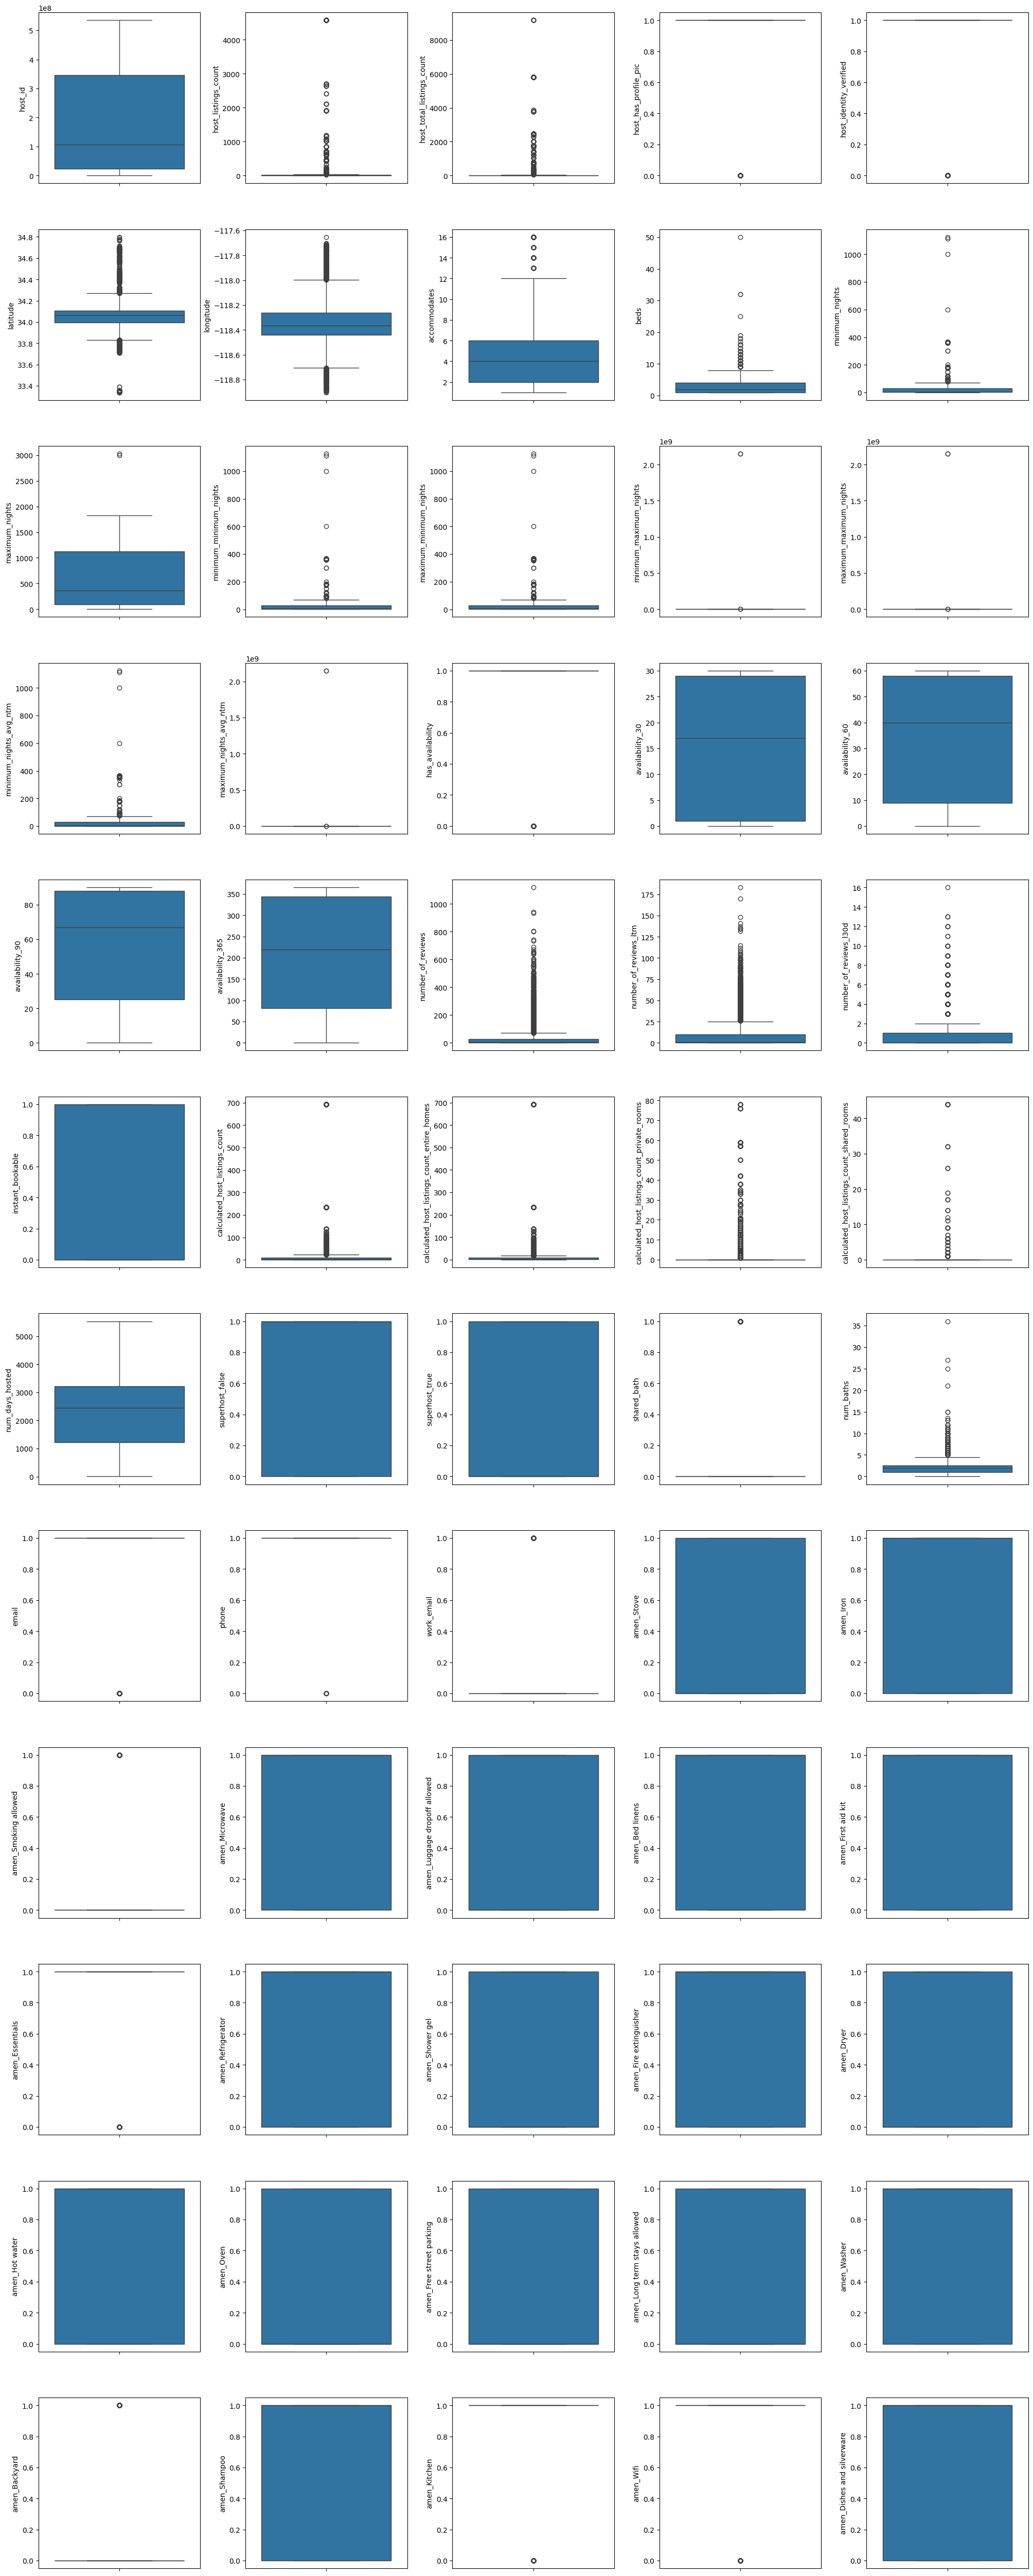

In [7]:
fig, axs = plt.subplots(ncols=5, nrows=12, figsize=(20, 50))
index = 0
axs = axs.flatten()  
for k,v in X_train.items():
    sns.boxplot(y=k, data=X_train, ax=axs[index])
    index += 1
    if index >= 60: 
        break
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Visualize Data with UMAP

<Axes: >

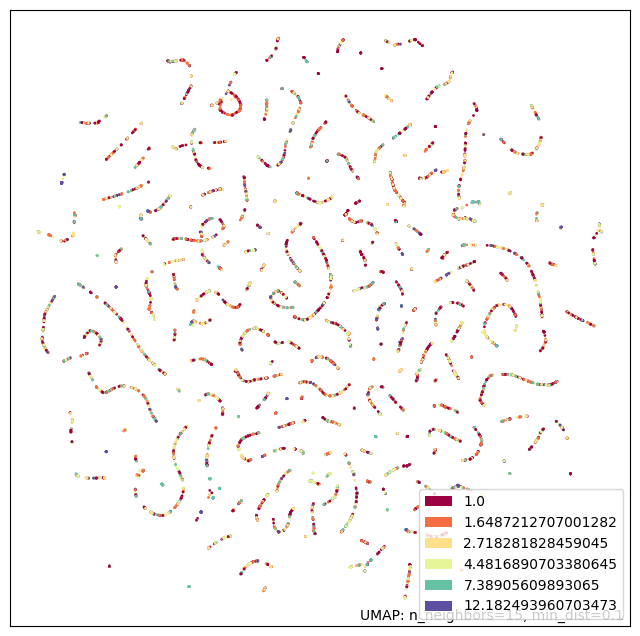

In [8]:
mapper_raw = umap.UMAP().fit(X_train)
umap.plot.points(mapper_raw, labels=y_train)

## Train Neural Net Feature Extractor

### Prepare dataloaders and set device

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class AirBnbDataset(Dataset): 
    
    def __init__(self, X, y): 
        
        # First, train the scaler to the preprocessed train set only 
        scaler = StandardScaler() 
        scaler.fit(X_train) 
        
        # now, convert this pandas dataframe to a numpy array and scale it 
        X = X.to_numpy().astype(float)
        X = scaler.transform(X) 
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float32)
        self.num_features = self.X.size()[1]
    
    def __len__(self): 
        return self.X.size()[0] 
    
    def __getitem__(self, i): 
        return (self.X[i, :], self.y[i])

trainset = AirBnbDataset(X_train, y_train) 
valset = AirBnbDataset(X_val, y_val)

trainloader = DataLoader(trainset,    # our dataset
                              batch_size=512,    # batch size
                              shuffle=True      # shuffling the data
                            )
valloader = DataLoader(valset, batch_size=512, shuffle=True)

In [148]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(), 
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def oneHot(y): 
    one_hot = torch.zeros(len(y), 6)
    for idx, class_num in enumerate(y):
        one_hot[idx, class_num] = 1 
    return one_hot

def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    correct = 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        # loss = loss_fn(pred, oneHot(y).to(device))
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        correct += (pred.to(torch.int32) == y.to(torch.int32)).type(torch.float).sum().item()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}% \n")
            
    return loss 
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # test_loss += loss_fn(pred, oneHot(y).to(device)).item()
            test_loss += loss_fn(pred, y).item()
            # print(torch.log(pred).to(torch.int32)[:5])
            # print(torch.log(y).to(torch.int32)[:5])
            correct += (pred.to(torch.int32) == y.to(torch.int32)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss 

In [150]:
model = NeuralNetwork(trainset.num_features).to(device)

# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(),     # which parameters to optimize
    lr=1e-3,                 # learning rate 
    momentum=0.9, 
    # weight_decay=1e-2
)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

epochs = 100
train_losses, val_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(trainloader, model, loss_fn, optimizer, scheduler))
    val_losses.append(test(valloader, model, loss_fn))
    # scheduler.step() 
    # print(f"lr : {optimizer.lr}")
print("Done!")

Epoch 1
-------------------------------
loss: 6.816588  [  512/11740]
Train Error: 
 Accuracy: 25.8% 

Test Error: 
 Accuracy: 27.42760%, Avg loss: 4.985018 

Epoch 2
-------------------------------
loss: 5.549110  [  512/11740]
Train Error: 
 Accuracy: 26.0% 

Test Error: 
 Accuracy: 28.07496%, Avg loss: 3.334709 

Epoch 3
-------------------------------
loss: 3.371716  [  512/11740]
Train Error: 
 Accuracy: 20.5% 

Test Error: 
 Accuracy: 17.41056%, Avg loss: 2.865904 

Epoch 4
-------------------------------
loss: 2.879187  [  512/11740]
Train Error: 
 Accuracy: 18.2% 

Test Error: 
 Accuracy: 17.51278%, Avg loss: 2.713607 

Epoch 5
-------------------------------
loss: 2.568044  [  512/11740]
Train Error: 
 Accuracy: 18.6% 

Test Error: 
 Accuracy: 18.46678%, Avg loss: 2.554143 

Epoch 6
-------------------------------
loss: 2.306308  [  512/11740]
Train Error: 
 Accuracy: 18.8% 

Test Error: 
 Accuracy: 18.90971%, Avg loss: 2.406255 

Epoch 7
-------------------------------
loss: 

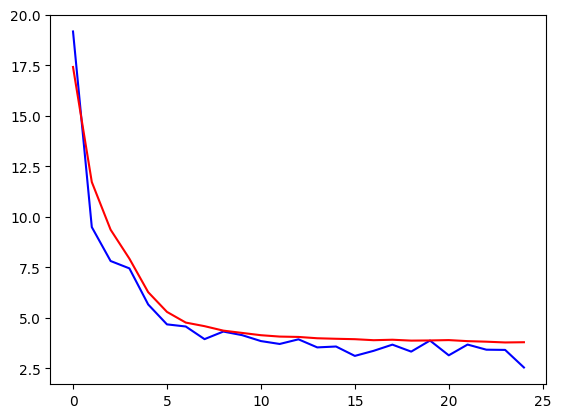

In [134]:
plt.plot([x.detach().cpu().numpy() for x in train_losses], c="b", label="Train Loss")
plt.plot([x for x in val_losses], c="r", label="Validation Loss")

## Just do Neural Network Predictions

In [143]:
scaler = StandardScaler() 
scaler.fit(X_train) 

X_test_input = X_test.to_numpy().astype(float)
X_test_input = scaler.transform(X_test_input) 
X_test_input = torch.tensor(X_test_input, dtype=torch.float32).to(device)

x_test_pred = model(X_test_input)
x_test_pred = torch.log(x_test_pred).to(torch.int32)
x_test_pred[50:100]


tensor([[0],
        [0],
        [2],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [2],
        [0],
        [0],
        [0],
        [2],
        [1],
        [1],
        [0],
        [2],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0]], device='cuda:0', dtype=torch.int32)

## Construct Backbone Network Feature Extractor

In [126]:
# Get just the feature extractor 
model_cp = NeuralNetwork(trainset.num_features).to(device)
for new_param, param in zip(model_cp.parameters(), model.parameters()):
    new_param.data.copy_(param.data)

model_cp.linear_relu_stack = nn.Sequential(*list(model_cp.linear_relu_stack.children())[:-1])
scaler = StandardScaler() 
scaler.fit(X_train) 


input = X_train.to_numpy().astype(float)
input = scaler.transform(input) 
input = torch.tensor(input, dtype=torch.float32).to(device)
X_train_features = model_cp(input).detach().cpu().numpy()

input = X_val.to_numpy().astype(float)
input = scaler.transform(input) 
input = torch.tensor(input, dtype=torch.float32).to(device)
X_val_features = model_cp(input).detach().cpu().numpy()

<Axes: >

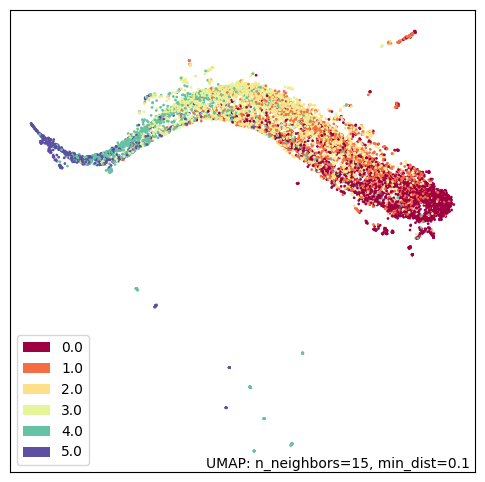

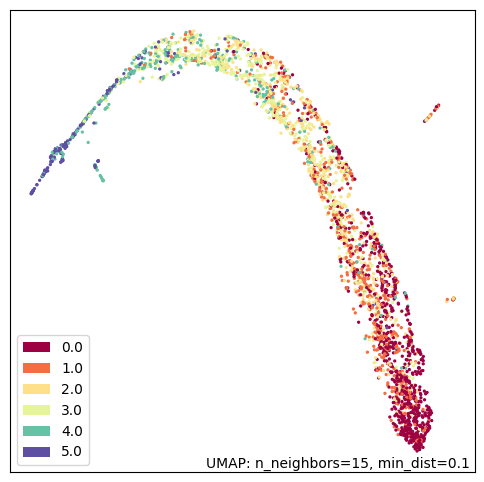

In [127]:
umap.plot.points(umap.UMAP().fit(X_train_features), labels=y_train, width=600, height=600)
umap.plot.points(umap.UMAP().fit(X_val_features), labels=y_val, width=600, height=600)

## Train Classical Models on Transformed Dataset

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


def decisionTree(hyperparameters):

    mod = DecisionTreeClassifier()

    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_mod = clf.fit(X_train_features, y_train)

    print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())

    val_input = X_val.to_numpy().astype(float)
    val_input = scaler.transform(val_input)
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device)

    y_pred = best_mod.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def randomForest(hyperparameters): 
    mod = RandomForestClassifier()

    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_mod = clf.fit(X_train_features,y_train)

    print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_mod.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def svc(hyperparameters): 
    svc = SVC(gamma="auto")

    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def linearsvc(hyperparameters): 
    svc = LinearSVC()

    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def nusvc(hyperparameters): 
    svc = NuSVC()

    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def knn(hyperparameters): 
    knn = KNeighborsClassifier()
    
    clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_knn = clf.fit(X_train_features,y_train)

    print('Best K neighbors:', best_knn.best_estimator_.get_params())

    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_knn.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def gradientBoost(hyperparameters): 
    gbm = GradientBoostingClassifier()

    clf = GridSearchCV(gbm, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_gbm = clf.fit(X_train_features,y_train)

    print('Best Parameters:', best_gbm.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_gbm.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def xgBoost(param_grid): 
    
    xgb = xgboost.XGBClassifier(
        objective="multi:softmax"
    )
    
    clf = GridSearchCV(xgb, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")
    
    best_xgb = clf.fit(X_train_features, y_train)
    
    print('Best Parameters:', best_xgb.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_xgb.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def adaBoost(param_grid): 

    # Adaboost with DecisionTree as base estimator
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier()
    )

    clf = GridSearchCV(ada, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")
    
    best_ada = clf.fit(X_train_features, y_train)
    
    print('Best Parameters:', best_ada.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_ada.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

In [12]:
hyperparameters = {
    # 'criterion': ["gini", "entropy"],
    # 'splitter': ["best", "random"],
    # 'max_depth': [40, 45, 50, 55],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': [None]
}
decisionTree(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END ..................................., score=0.500 total time=   1.3s
[CV 1/5] END ..................................., score=0.498 total time=   1.3s
[CV 5/5] END ..................................., score=0.517 total time=   1.3s
[CV 4/5] END ..................................., score=0.496 total time=   1.3s
[CV 3/5] END ..................................., score=0.518 total time=   1.3s
Best Parameter Estimates: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recall  f1-score   support

         0.0    0.72333   0.72512   0.72422       804
         1.0    0.36177   0.38061   0.37095       557
         2.0    0.31942   0.29767   0.30816       514
         3.0  

In [13]:
hyperparameters = {
    # 'n_estimators': [300, 400],
    # 'class_weight' : [None], 
    # 'max_depth': [20, 30, 40, 50],
    # 'min_samples_split': [5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['log2', 'sqrt'], 
    # 'criterion': ["gini", "entropy", "log_loss"]
}
randomForest(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END ..................................., score=0.608 total time=   6.8s
[CV 2/5] END ..................................., score=0.599 total time=   6.8s
[CV 3/5] END ..................................., score=0.632 total time=   6.8s
[CV 1/5] END ..................................., score=0.609 total time=   6.9s
[CV 4/5] END ..................................., score=0.591 total time=   6.9s
Best Parameter Estimates: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

         0.0    0.72893   0.79602   0.76100       804
        

In [32]:
mod = RandomForestClassifier()

hyperparameters = {
    'n_estimators': [300, 400],
    'class_weight' : [None], 
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt'], 
    # 'criterion': ["gini", "entropy", "log_loss"]
}

clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

best_mod = clf.fit(X_train_features,y_train)

print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())

### 

val_input = X_val.to_numpy().astype(float) 
val_input = scaler.transform(val_input) 
val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

y_pred = best_mod.predict(model_cp(val_input).detach().cpu().numpy())
print(classification_report(y_val, y_pred, digits=5))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 5/5] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.606 total time=  10.7s
[CV 4/5] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.598 total time=  11.0s
[CV 2/5] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.602 total time=  11.2s
[CV 1/5] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.613 total time=  11.2s
[CV 3/5] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.627 total time=  11.8s
[CV 2/5] END class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=0.599 total time=  11.9s

In [27]:
test_input = X_test.to_numpy().astype(float)
test_input = scaler.transform(test_input) 
test_input = torch.tensor(test_input, dtype=torch.float32).to(device)

test_predictions = best_mod.predict(model_cp(test_input).detach().cpu().numpy())

submission = {
    "id" : list(range(len(test_predictions))), 
    "price" : list(test_predictions.astype(float))
}

submission = pd.DataFrame.from_dict(submission)

submission.to_csv(os.path.join("submissions/", "bahng_rf7.csv"), index=False)

In [14]:
hyperparameters = {
    "dual" : [True, False], 
    "multi_class" : ["ovr", "crammer_singer"]
}
linearsvc(hyperparameters)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END .......dual=False, multi_class=ovr;, score=0.581 total time=   3.5s
[CV 2/5] END .......dual=False, multi_class=ovr;, score=0.605 total time=   3.8s
[CV 1/5] END .......dual=False, multi_class=ovr;, score=0.598 total time=   3.8s[CV 4/5] END .......dual=False, multi_class=ovr;, score=0.587 total time=   3.8s

[CV 3/5] END .......dual=False, multi_class=ovr;, score=0.609 total time=   4.1s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ........dual=True, multi_class=ovr;, score=0.584 total time=  13.0s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ........dual=True, multi_class=ovr;, score=0.603 total time=  14.7s
[CV 4/5] END ........dual=True, multi_class=ovr;, score=0.588 total time=  14.8s
[CV 3/5] END ........dual=True, multi_class=ovr;, score=0.604 total time=  14.8s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ........dual=True, multi_class=ovr;, score=0.595 total time=  15.4s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END dual=False, multi_class=crammer_singer;, score=0.581 total time=  30.5s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END dual=True, multi_class=crammer_singer;, score=0.585 total time=  30.4s
[CV 1/5] END dual=False, multi_class=crammer_singer;, score=0.585 total time=  30.9s
[CV 5/5] END dual=True, multi_class=crammer_singer;, score=0.581 total time=  30.3s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END dual=True, multi_class=crammer_singer;, score=0.604 total time=  30.9s
[CV 4/5] END dual=False, multi_class=crammer_singer;, score=0.590 total time=  31.6s
[CV 2/5] END dual=False, multi_class=crammer_singer;, score=0.598 total time=  31.7s
[CV 4/5] END dual=True, multi_class=crammer_singer;, score=0.590 total time=  31.1s
[CV 3/5] END dual=False, multi_class=crammer_singer;, score=0.604 total time=  31.7s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END dual=True, multi_class=crammer_singer;, score=0.597 total time=  31.7s
Best hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
              precision    recall  f1-score   support

         0.0    0.70159   0.82463   0.75815       804
         1.0    0.41207   0.42908   0.42040       557
         2.0    0.34539   0.20428   0.25672       514
         3.0    0.42546   0.49416   0.45725       514
         4.0    0.40798   0.42357   0.41562       314
         5.0    0.71585   0.56466   0.63133       232

    accuracy                        0.51959      2935
   macro avg    0.50139   0.49006   0.48991      2935
weighted avg    0.50562   0.51959   0.50687      2935



In [16]:
hyperparameters = {
    # "cache_size" : [70, 80, 90, 100], 
    # "C": [1.0, 2.0]
}
svc(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.609 total time=   4.8s
[CV 4/5] END ..................................., score=0.597 total time=   5.0s
[CV 2/5] END ..................................., score=0.601 total time=   5.0s
[CV 3/5] END ..................................., score=0.620 total time=   5.5s
[CV 5/5] END ..................................., score=0.600 total time=   5.5s
Best hyperparameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

         0.0    0.72737   0.81965   0.77076       804
         1.0    0.43327   0.42549   0.42935       557
         2.0    0.35866   0.22957   0.27995       514
         3.0    0.

In [17]:
hyperparameters = dict(n_neighbors=list(range(1,50)))
knn(hyperparameters)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 4/5] END .....................n_neighbors=1;, score=0.517 total time=   0.2s
[CV 1/5] END .....................n_neighbors=1;, score=0.513 total time=   0.2s
[CV 5/5] END .....................n_neighbors=2;, score=0.537 total time=   0.2s
[CV 2/5] END .....................n_neighbors=1;, score=0.516 total time=   0.2s
[CV 2/5] END .....................n_neighbors=4;, score=0.548 total time=   0.2s
[CV 3/5] END .....................n_neighbors=3;, score=0.554 total time=   0.2s
[CV 4/5] END .....................n_neighbors=4;, score=0.546 total time=   0.2s
[CV 5/5] END .....................n_neighbors=4;, score=0.559 total time=   0.2s
[CV 1/5] END .....................n_neighbors=4;, score=0.544 total time=   0.2s
[CV 1/5] END .....................n_neighbors=3;, score=0.531 total time=   0.3s
[CV 2/5] END .....................n_neighbors=3;, score=0.534 total time=   0.3s
[CV 3/5] END .....................n_neighbors=1

In [29]:
hyperparameters = dict() #n_estimators = list([150]))
gradientBoost(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END ..................................., score=0.617 total time= 2.8min
[CV 4/5] END ..................................., score=0.587 total time= 2.8min
[CV 1/5] END ..................................., score=0.610 total time= 2.8min
[CV 5/5] END ..................................., score=0.597 total time= 2.8min
[CV 2/5] END ..................................., score=0.600 total time= 2.8min
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

         0.0    0.74212

In [19]:
param_grid = {
    'n_estimators' : [10, 30, 50, 70],
    'learning_rate' : [0.01, 0.03, 0.1, 0.3]
}
adaBoost(param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.01, n_estimators=30;, score=0.500 total time=   1.4s
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.501 total time=   1.4s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.514 total time=   1.4s
[CV 2/5] END learning_rate=0.01, n_estimators=70;, score=0.501 total time=   1.4s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.497 total time=   1.4s
[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.493 total time=   1.4s
[CV 4/5] END learning_rate=0.01, n_estimators=70;, score=0.500 total time=   1.4s
[CV 3/5] END learning_rate=0.01, n_estimators=70;, score=0.509 total time=   1.5s
[CV 3/5] END learning_rate=0.01, n_estimators=30;, score=0.509 total time=   1.6s
[CV 5/5] END learning_rate=0.01, n_estimators=30;, score=0.514 total time=   1.5s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.494 total time=   1.6s
[CV 4/5] END learning_rate=0.01, n_es

In [20]:
param_grid = {
    'n_estimators' : [10, 30, 50, 70],
    'learning_rate' : [0.01, 0.03, 0.1, 0.3]
}
xgBoost(param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 5/5] END ..................................., score=0.595 total time=   9.3s
[CV 3/5] END ..................................., score=0.614 total time=   9.4s
[CV 1/5] END ..................................., score=0.598 total time=   9.5s
[CV 4/5] END ..................................., score=0.585 total time=   9.5s
[CV 2/5] END ..................................., score=0.598 total time=   9.7s
Best Parameters: {'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan,